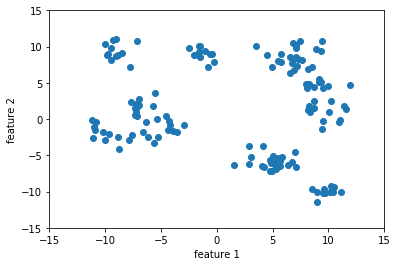

In [155]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

# Setting the boundary box for the graphs
xlim = [-15, 15]
ylim = [-15, 15]


# Matplotlib magic
%matplotlib inline
np.random.seed(4)

# Creating the train data
n_features = 2
n_centers = 12
points, classes = make_blobs(n_features=n_features, n_samples=n_centers*12, centers=n_centers)

# Graph
X, Y = np.dstack(points)[0]
plt.scatter(X, Y)

# Labeling axis
plt.xlabel('feature 1', size=10)
plt.ylabel('feature 2', size=10)

# Setting axis range
plt.xlim((xlim[0], xlim[1]))
plt.ylim((ylim[0], ylim[1]))
plt.show()

In [156]:
class ClusteringAlgorithms():
    def __init__(self, training_points):
        self.train = training_points
        centroids = []
        
    @staticmethod
    def classify(point, centroids):
        """
        Label given point with closest centroid index
        """
        return np.argmin([np.linalg.norm(point - centroid) for centroid in centroids])
    
    def error(self, centroids):
        """
        Calculates squared error across centroids
        """
        # Find squared error between training points and label
        err = 0
        for point in self.train:
            label = ClusteringAlgorithms.classify(point, centroids)
            err += (point - centroids[label])**2
        return sum(err)
    
    def plot(self):
        raise NotImplementedError()        

# K Means

### Hyper Parameters:
K := Number of centroids to initialize

### Centroid Update Rule:
For every epoch, label each train data point with the closest centroid. All centroids are repositioned to the average of all their corresponding labeled train data points

### Other Notes
One issue with KMeans is we don't know the original number of clusters, which is why K is a hyper parameter. This makes kmeans hyper sensitive to outliers because you can have a centroid which sticks to an outlier. In practice it's best to run several iterations of KMeans, and then choose the trial which has the lowest squared error. You'll notice in the code below that the method fit() runs a singular trial where we stop the trial once the centroids stop moving, while best_fit() runs several trials and chooses the one with the smallest error.

In [157]:
class KMeans(ClusteringAlgorithms):
    def __init__(self, training_points, k):
        super().__init__(training_points)
        self.k = k
        
    def plot(self, centroids):
        """
        Plots graph
        
        :param centroids: numpy array of centroids to plot alongside internal training points
        """
        # np.dstack(arr)[0] turns arr which equals [[x1,y1], [x2,y2]] into [[x1,x2], [y1,y2]] 
        points = np.dstack(self.train)[0]
        X = points[0]
        Y = points[1]
        
        # np.dstack(arr)[0] turns arr which equals [[x1,y1], [x2,y2]] into [[x1,x2], [y1,y2]]
        cent_points = np.dstack(centroids)[0]
        cent_x = cent_points[0]
        cent_y = cent_points[1]
        
        # Add points to scatter plot
        plt.scatter(X, Y, label='data points', color='blue')
        plt.scatter(cent_x, cent_y, color='yellow', label='centroids')
        
        # Label axis
        plt.xlabel('feature 1', size=10)
        plt.ylabel('feature 2', size=10)
        
        # Add axis range
        plt.xlim((xlim[0], xlim[1]))
        plt.ylim((ylim[0], ylim[1]))
        
        # Plot and close graph
        plt.legend()
        plt.show()
        plt.close()
    
    def fit(self, plotEpochs=True):
        """
        Runs iterative kmeans shift until centroids no longer move
        
        :param plotEpochs: boolean value used to determine whether we will plot
            the various epochs of a trial. If false, fit will not plot anything
        :returns centroids: returns the final centroids after fitting
        """
        centroids = np.random.uniform(-5, 10, size=(self.k, n_features))
        
        # Here we will stop when the centroids stop moving
        epoch = 0
        if plotEpochs:
            plt.title('Epoch {0}'.format(epoch), fontsize=20)
            self.plot(centroids)
        
        previous_centroids = np.array([])
        # Stop when previous centroids equals current centroids, or in other words when the centroids stop moving
        while (not np.array_equal(previous_centroids, centroids)):
            epoch += 1
            
            # Initialize new future centroids, and previous centroids along with metrics to help calculate average
            previous_centroids = centroids.copy()
            shape = centroids.shape
            next_centroids = np.zeros( shape )
            num_points_per_centroid = np.zeros( shape[0] )
            
            # Bread and butter of kmeans. Iterates through every point and effectively labels the points by updating 
            # the new centroids
            for point in self.train:
                label = KMeans.classify(point, centroids)
                num_points_per_centroid[label] += 1
                next_centroids[label] += point
                
            # Finish evaluating the new centroids
            for i in range(len(next_centroids)):
                if num_points_per_centroid[i] != 0:
                    next_centroids[i] /= num_points_per_centroid[i]
            
            centroids = next_centroids
            
            # Plot if plotEpochs is true
            if plotEpochs:
                plt.title('Epoch {0}'.format(epoch), fontsize=20)
                self.plot(centroids)
        return centroids
           
    def bestFit(self, num_trials, plotEpochs=False):
        """
        Runs several iterations of kmeans shift and chooses the iteration with the smallest squared error
        
        :param num_trials: Integer representing the number of trials to plot
        :param plotEpochs: Bool representing whether to plot each trial's epoch plot
        """
        centroids = []
        err = float('inf')
        for i in range(num_trials):
            if plotEpochs:
                print('Beginning Trial {0}'.format(i))
            
            # Fit new centroids
            newCentroids = self.fit(plotEpochs=plotEpochs)
            
            # Calculate squared error
            newErr = self.error(newCentroids)
            
            # If current iteration has smaller error, save centroids
            if newErr < err:
                centroids = newCentroids
                err = newErr
                
        plt.title('Best fit', fontsize=20)
        self.plot(centroids)

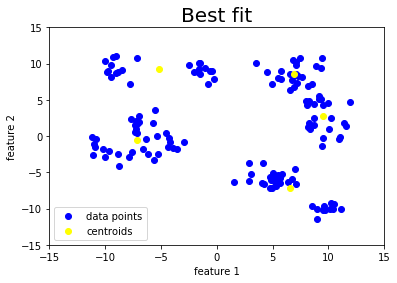

In [158]:
num_trials = 20
kmeans = KMeans(points, 5)
kmeans.bestFit(num_trials)


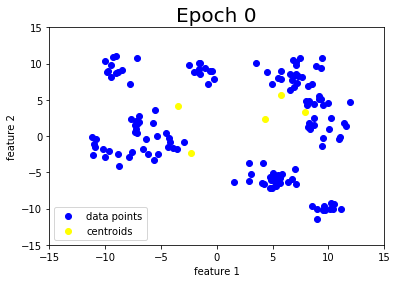

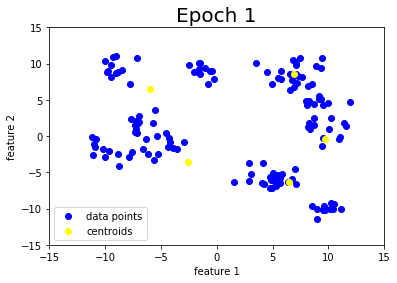

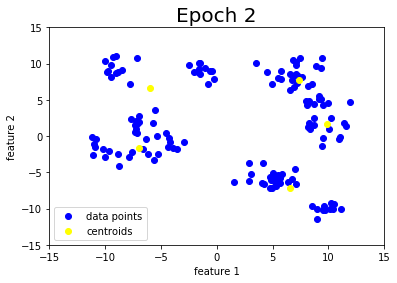

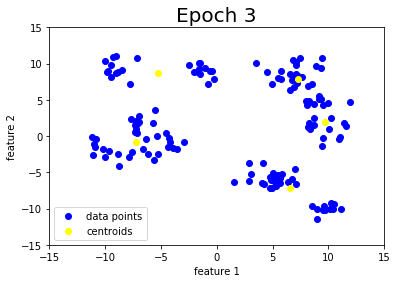

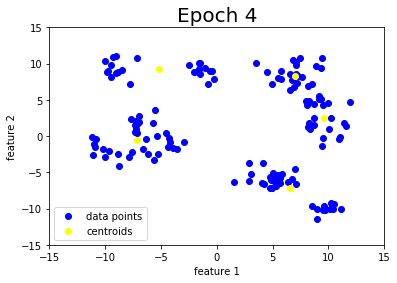

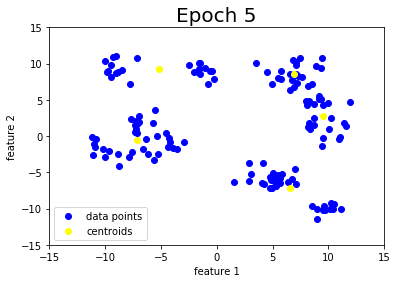

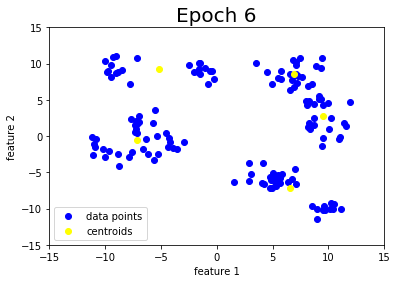

array([[-7.14981609, -0.59621765],
       [ 6.915909  ,  8.60369662],
       [-5.152514  ,  9.19294955],
       [ 6.53939557, -7.22147034],
       [ 9.49070176,  2.71916141]])

In [159]:
# Example KMeans Fit
kmeans.fit()

# Mean Shift

### Hyper Parameters:

kernel_bandwidth/bandwidth := The radius of each kernel/centroid bandwidth

### Centroid Update Rule:

First initialize one centroid at every location where there is a train data point. For every epoch iteration, iterate through centroid and only pick points whose distance (in this case euclidean distance) is within the centroids bandwidth. All centroids new position will be equivalent to the average of every train data point within that centroids kernel_bandwidth

### Other Notes

Mean Shift runs in n^2 time for you have n points and n centroids and each iteration every point could see every centroid. Potential speedups include only iterating through points within the centroid's kernel_bandwidth. Additionally, mean shift is a hierarchal clustering algorithm because a point can belong to several clusters. We can utilize Kernel Density Estimation to create a probability density function using our centroids to assign probabilities for which cluster a given point belongs to, however KDE is outside the scope of this workshop

In [160]:
class MeanShift(ClusteringAlgorithms):
    def __init__(self, training_points, kernel_bandwidth):
        super().__init__(training_points)
        self.bandwidth = kernel_bandwidth
    
    @staticmethod
    def euclidean_distance(p1, p2):
        """
        Finds euclidean distance between 2 points. Specifically, if p1=(x1, y1) and
        p2=(x2, y2), finds sqrt((x1-x2)^2 + (y1-y2)^2)
        
        :param p1: first numpy array or list of shape [2]. Will be used to calculate euclidean distance
        :param p2: second numpy array or list of shape [2]. Will be used to calculate euclidean distance
        :returns: euclidean distance between the two points
        """
        return np.linalg.norm(p1 - p2)

    def plot(self, centroids):
        """
        Plots graph
        
        :param centroids: The centroids which will be plotted against the internal train data points 
        """
        
        # Set the graphs axis range
        plt.xlim((xlim[0], xlim[1]))
        plt.ylim((ylim[0], ylim[1]))
        
        # Set graphs axis label
        plt.xlabel('feature 1')
        plt.ylabel('feature 2')
        
        # np.dstack(arr)[0] turns arr which equals [[x1,y1], [x2,y2]] into [[x1,x2], [y1,y2]]
        points = np.dstack(self.train)[0]
        X = points[0]
        Y = points[1]
        
        # np.dstack(arr)[0] turns arr which equals [[x1,y1], [x2,y2]] into [[x1,x2], [y1,y2]]
        cent_points = np.dstack(centroids)[0]
        cent_x = cent_points[0]
        cent_y = cent_points[1]
        
        # Plots points onto scatter plot
        plt.scatter(X, Y, label='data points', color='blue')
        plt.scatter(cent_x, cent_y, color='yellow', label='centroids')
        
        # Plots the kernel bandwidth for each centroid
        for centroid in centroids:
            circle = plt.Circle(centroid, radius=self.bandwidth, color='red', fill=False)
            plt.gcf().gca().add_artist(circle)
        
        # Plot
        plt.legend()
        plt.show()
        plt.close()
    
    def fit(self):
        """
        Runs mean shift until centroids stop moving
        """
        # Put centroids at every training point
        centroids = self.train.copy()
        
        epoch = 0
        plt.title('Epoch {0}'.format(epoch), fontsize=20)
        self.plot(centroids)
        
        previous_centroids = np.array([])
        
        # Stop when previous centroids equals current centroids, or in other words when the centroids stop moving
        while (not np.array_equal(previous_centroids, centroids)):
            epoch += 1
            
            # Initialize previous centroids and future centroids along with average metrics
            previous_centroids = centroids.copy()
            shape = centroids.shape
            next_centroids = np.zeros( shape )
            num_points_per_centroid = np.zeros( shape[0] )
            
            # Find every point within each centroids kernel bandwidth and move the kernel towards the average
            # of all of these points
            for point in self.train:
                for i, centroid in enumerate(centroids):
                    if self.euclidean_distance(point, centroid) <= self.bandwidth:
                        num_points_per_centroid[i] += 1
                        next_centroids[i] += point
                
            # Finalize average metric
            for i in range(len(next_centroids)):
                next_centroids[i] /= num_points_per_centroid[i]
            
            # Assign next centroids
            centroids = next_centroids
            
            # Plot
            plt.title('Epoch {0}'.format(epoch), fontsize=20)
            self.plot(centroids)


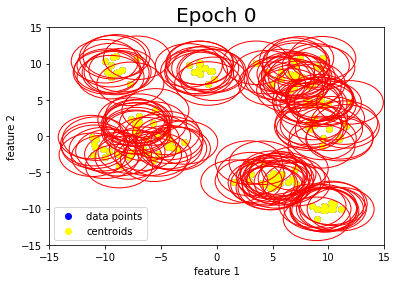

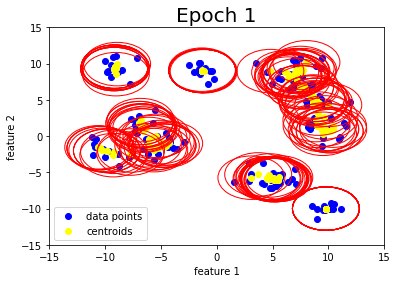

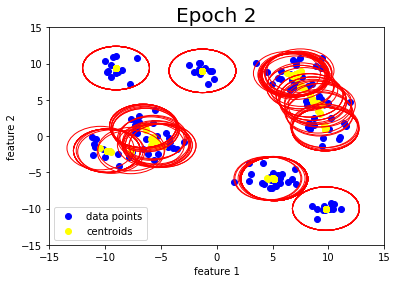

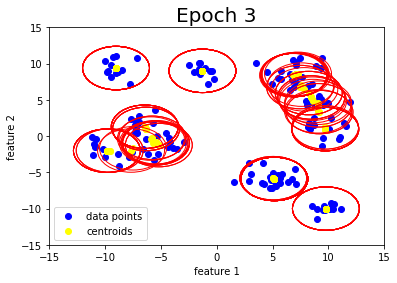

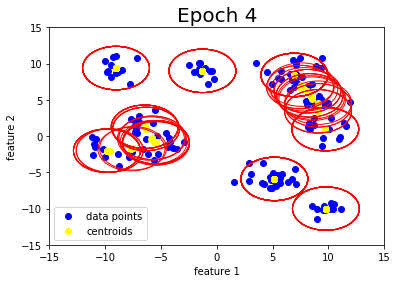

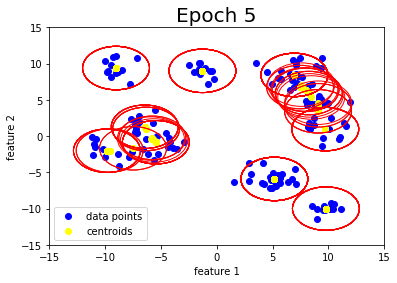

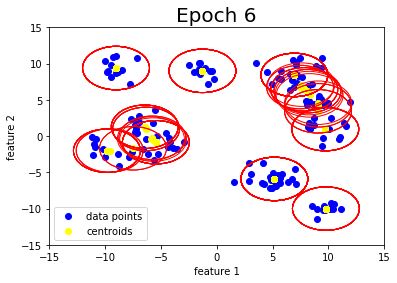

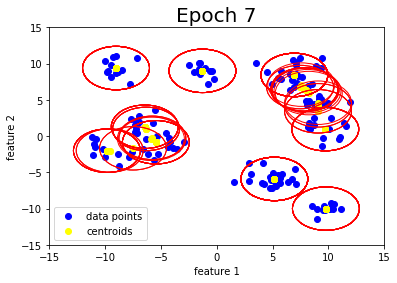

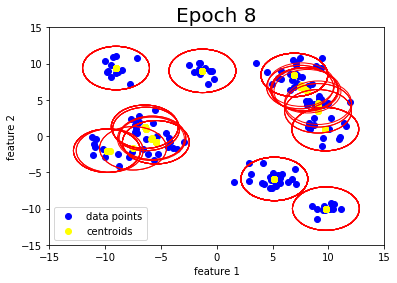

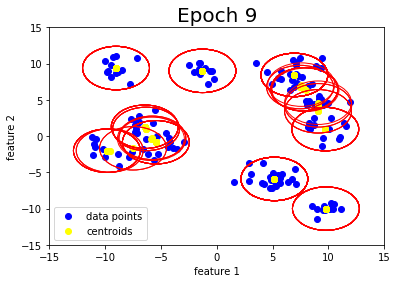

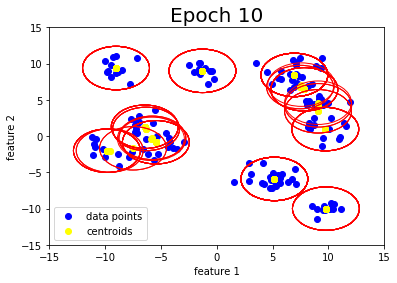

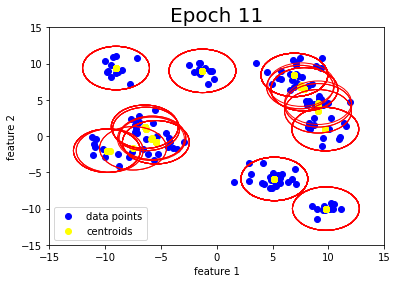

In [161]:
meanshift = MeanShift(points, 3)
meanshift.fit()